In [126]:
import numpy as np
import os
import glob
import math
import nibabel as nib
import cv2

# from pycimg import CImg
from skimage import measure
from skimage import morphology
from scipy import ndimage
from scipy.spatial import ConvexHull


## Load / save .nii files 

In [127]:
def load_nii_gz_file(file_path: str) -> tuple:
    nii_img = nib.load(file_path)
    nii_data = nii_img.get_fdata()
    return nii_data, nii_img.affine

def save_to_nii(segmented_data: np.ndarray, affine: np.ndarray, output_path: str) -> None:
    segmented_nii = nib.Nifti1Image(segmented_data.astype(np.uint8), affine)
    nib.save(segmented_nii, output_path)
    
def view_nii_data(nii_data: np.ndarray) -> None:
    for i in range(nii_data.shape[2]):
        cv2.imshow('slice', nii_data[:, :, i])
        cv2.waitKey(0)
    cv2.destroyAllWindows()

## Segmentation

In [128]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters


def otsu_segmentation(image_data: np.ndarray) -> np.ndarray:
    threshold = filters.threshold_otsu(image_data)
    # get binary mask
    segmented_img = image_data > threshold
    return segmented_img


def visualize_segmentation(original: np.ndarray, segmented: np.ndarray, reference: np.ndarray, slice_num: int=50) -> None:
    plt.figure(figsize=(15, 5))

    # Original slice
    plt.subplot(1, 3, 1)
    plt.title("Original Slice")
    plt.imshow(original[:, :, slice_num], cmap="gray")
    # Segmented slice
    plt.subplot(1, 3, 2)
    plt.title("Segmented Slice")
    plt.imshow(segmented[:, :, slice_num], cmap="gray")
    # Reference slice
    plt.subplot(1, 3, 3)
    plt.title("Reference Slice")
    plt.imshow(reference[:, :, slice_num], cmap="gray")
    
    plt.show()

In [129]:
def perform_transform(image_data: np.ndarray, slice: int) -> np.ndarray:
    image_data[:, :, slice] = morphology.binary_erosion(image_data[:, :, slice], morphology.disk(4))
    image_data[:, :, slice] = morphology.binary_dilation(image_data[:, :, slice], morphology.disk(3))
    image_data[:, :, slice] = (image_data[:, :, slice] > 0).astype(np.uint8)
    image_data[:, :, slice] = ndimage.binary_fill_holes(image_data[:, :, slice])
        
def transform_image(image_data: np.ndarray, slice: int = float("inf")) -> np.ndarray:
    segmented_img = otsu_segmentation(image_data)
    if slice == float("inf"):
        for i in range(segmented_img.shape[2]):
            perform_transform(segmented_img, i)
    else:
        perform_transform(segmented_img, slice)  
    return segmented_img


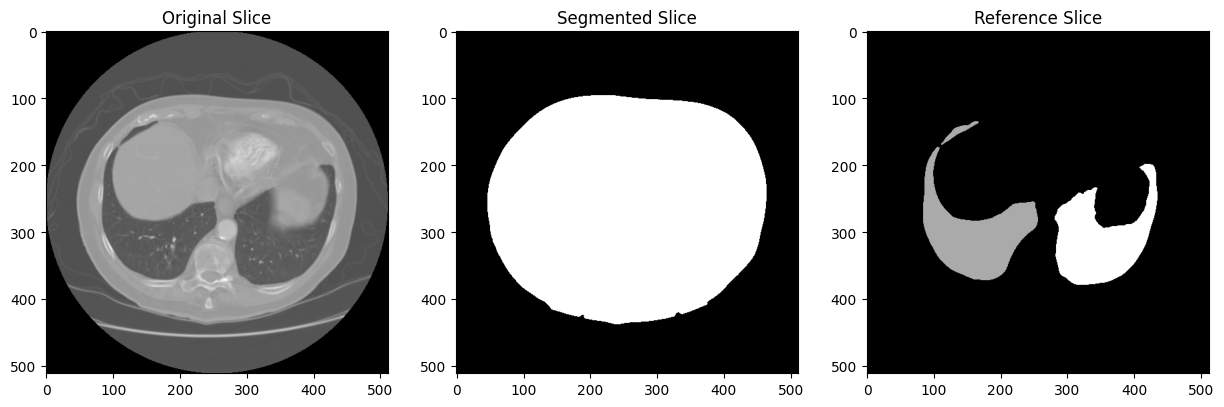

In [130]:

image_data, affine = load_nii_gz_file('Images/IMG_0001.nii.gz')
reference_data, affine_data = load_nii_gz_file('ReferenceSegmentations/LUNGS_IMG_0001.nii.gz')
segmented_data = transform_image(image_data)
save_to_nii(segmented_data, affine, 'result/')
visualize_segmentation(image_data, segmented_data,reference_data, slice_num=51)
